# 二手房交易分析

## 目标

通过数据分析，对后续二手房交易策略提供支持，计划进行如下维度分析

1. 小区户型交易热点，掌握哪些户型易于成交
2. 用户行为，户型与交易周期的关系，了解一个新挂的二手房，什么情况下可能成交，以及相应的议价空间
3. 交易趋势，确认政策对交易的量化影响，以及目前的价格走势

随后形成如下认知：

1. 户型后续出手难度
2. 户型定价策略，报价博弈策略
3. 潜在竞争客户应对策略

最终用户如下决策

1. 买什么户型
2. 报多少价格
3. 如何进行议价

# 结论模板

1. 交易热点：小区成交热点户型，面积，朝向，楼层
2. 交易趋势：成交均价随月份趋势和分布，挂牌价与成交价gap的均值和线框图
3. 交易行为：成交前平均带看次数和成交周期分布和趋势

# 通用结论

影响价格因素：户型，朝向，楼层

朝向好，价格高

楼层方面：无电梯小区，底层、低楼层，中楼层价格相近，高于高层和顶层

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
pd.set_option("display.max_rows", None)
#pd.reset_option("display.max_rows")

# 一. 数据载入&预处理

In [3]:
# 载入数据
#data = pd.read_csv('../教场口6号院.csv')
data = pd.read_csv('../安定路.csv')

In [4]:
# 预览数据
data.head(3)

,title,deal_date,community,house_type,floor,area,building_type,orientation,build_year,lianjia_id,listing_time,last_transaction_duration,transaction_price,history_trade_count,listed_price,transaction_duration,price_change_count,visit_count,follower_count,page_view_count
0,安定路 2室1厅 59.44平米,2019.12,安定路,2室1厅1厨1卫,高楼层(共18层),59.44㎡,塔楼,南,1996,101105857518,2019-09-27,暂无数据,599-612,2,630,66,1,21,30,606
1,安定路 3室2厅 94平米,2019.09,安定路,3室2厅1厨1卫,低楼层(共18层),94㎡,塔楼,南 西,1996,101084743650,2012-07-25,满两年,852-869,2,400,2594,0,0,0,暂无数据
2,安定路 3室1厅 88.09平米,2019.09.11,安定路,3室1厅1厨1卫,低楼层(共20层),88.09㎡,塔楼,南 北,1995,101105495470,2019-08-17,满两年,696,1,720,26,0,17,35,484


In [5]:
# 预览大小和特征数
data.shape

(122, 20)

In [6]:
#处理日期数据
data['deal_date'] = pd.to_datetime(data['deal_date'])
data['listing_time'] = pd.to_datetime(data['listing_time'], errors='coerce')
data['deal_month'] = data['deal_date'].dt.to_period('M').dt.to_timestamp()
data['deal_year'] = data['deal_date'].dt.to_period('Y').dt.to_timestamp()

In [7]:
# 转成整数类型日期
data['deal_month_num'] = data['deal_month'].dt.strftime('%Y%m')
data['deal_month_num'] = data['deal_month_num'].map(lambda x:int(x) if isinstance(x, str) else x)

In [8]:
data.dtypes

title                                object
deal_date                    datetime64[ns]
community                            object
house_type                           object
floor                                object
area                                 object
building_type                        object
orientation                          object
build_year                           object
lianjia_id                           object
listing_time                 datetime64[ns]
last_transaction_duration            object
transaction_price                    object
history_trade_count                   int64
listed_price                         object
transaction_duration                 object
price_change_count                    int64
visit_count                           int64
follower_count                        int64
page_view_count                      object
deal_month                   datetime64[ns]
deal_year                    datetime64[ns]
deal_month_num                  

In [9]:
# 处理数值型数据转换
# 成交周期
data['transaction_duration'] = data['transaction_duration'].map(lambda x: np.nan if x=='暂无数据' or x is np.nan else int(x)).astype('Int64',errors='ignore')
# 面积
data['area'] = data['area'].map(lambda x: float(x.strip('㎡') if x != '暂无数据' else np.nan))
# 判断是否是链家成交
def is_lianjia_deal(priceStr):
    if priceStr == '暂无数据':
        return False
    elif '-' not in priceStr:
        return True
    else:
        return False
data['is_lianjia_deal'] = data['transaction_price'].map(is_lianjia_deal)
# 成交价
def convert_int(numberStr):
    if isinstance(numberStr, int) or isinstance(numberStr, float):
        return numberStr
    if numberStr == '暂无数据':
        return np.nan
    elif '.' in numberStr:
        return int(numberStr.split('.')[0])
    elif '-' not in numberStr:
        return int(numberStr)
    else:
        low,up = numberStr.split('-')
        return int((int(low)+int(up))/2)
data['transaction_price'] = data['transaction_price'].map(convert_int)

# 挂牌价
data['listed_price'] = data['listed_price'].map(convert_int).astype('Int64')

# 浏览数
data['page_view_count'] = data['page_view_count'].map(convert_int).astype('Int64')

In [10]:
#处理字符串类型
# 朝向
data['orientation'] = data['orientation'].map(lambda x: ''.join(set([i for i in x if i != ' '])))

In [11]:
# 新列
# 每平米价格
data['per_area_price'] = data['transaction_price']/data['area']
# 成交价-报价
data['transaction_listed_price_gap'] = data['transaction_price']-data['listed_price']

def convert_area_level(area):
    return int(round(area/10))*10

def convert_room_count(house_type):
    try:
        return int(house_type[0])
    except Exception:
        return 0

# 面积阶梯
data['area_level'] = data['area'].map(convert_area_level)
# 房间数归一化
data['room_count'] = data['house_type'].map(convert_room_count)

In [12]:
data.dtypes

title                                   object
deal_date                       datetime64[ns]
community                               object
house_type                              object
floor                                   object
area                                   float64
building_type                           object
orientation                             object
build_year                              object
lianjia_id                              object
listing_time                    datetime64[ns]
last_transaction_duration               object
transaction_price                        int64
history_trade_count                      int64
listed_price                             Int64
transaction_duration                     Int64
price_change_count                       int64
visit_count                              int64
follower_count                           int64
page_view_count                          Int64
deal_month                      datetime64[ns]
deal_year    

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 28 columns):
title                           122 non-null object
deal_date                       122 non-null datetime64[ns]
community                       122 non-null object
house_type                      122 non-null object
floor                           122 non-null object
area                            122 non-null float64
building_type                   122 non-null object
orientation                     122 non-null object
build_year                      122 non-null object
lianjia_id                      122 non-null object
listing_time                    121 non-null datetime64[ns]
last_transaction_duration       122 non-null object
transaction_price               122 non-null int64
history_trade_count             122 non-null int64
listed_price                    113 non-null Int64
transaction_duration            93 non-null Int64
price_change_count              122 non-null int64


In [14]:
data.head(3)

,title,deal_date,community,house_type,floor,area,building_type,orientation,build_year,lianjia_id,...,follower_count,page_view_count,deal_month,deal_year,deal_month_num,is_lianjia_deal,per_area_price,transaction_listed_price_gap,area_level,room_count
0,安定路 2室1厅 59.44平米,2019-12-01,安定路,2室1厅1厨1卫,高楼层(共18层),59.44,塔楼,南,1996,101105857518,...,30,606,2019-12-01,2019-01-01,201912,False,10.178331,-25,60,2
1,安定路 3室2厅 94平米,2019-09-01,安定路,3室2厅1厨1卫,低楼层(共18层),94.00,塔楼,南西,1996,101084743650,...,0,NaN,2019-09-01,2019-01-01,201909,False,9.148936,460,90,3
2,安定路 3室1厅 88.09平米,2019-09-11,安定路,3室1厅1厨1卫,低楼层(共20层),88.09,塔楼,南北,1995,101105495470,...,35,484,2019-09-01,2019-01-01,201909,True,7.901010,-24,90,3


# 二. 数据分析

户型种类

In [15]:
print(data['house_type'].unique())

['2室1厅1厨1卫' '3室2厅1厨1卫' '3室1厅1厨1卫' '4室1厅1厨1卫' '1室1厅1厨1卫' '2室2厅1厨1卫'
 '3室2厅1厨2卫' '3室1厅' '1室1厅' '2室1厅']


建成年代

In [16]:
print(data['build_year'].unique())

['1996' '1995' '1993' '未知']


链家成交占比


In [17]:
data[data['is_lianjia_deal']==True]['title'].count()/data['title'].count()

0.6721311475409836

## 2.1 交易行为

### 1）户型交易分布

可以查看交易主力户型和朝向

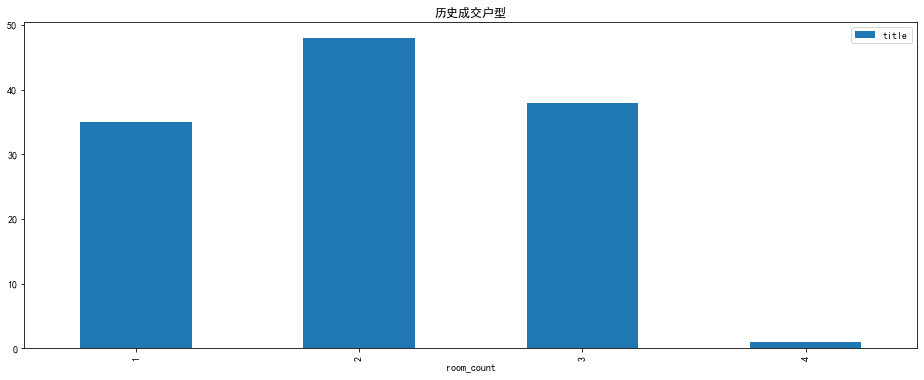

In [18]:
data.groupby(['room_count']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交户型')

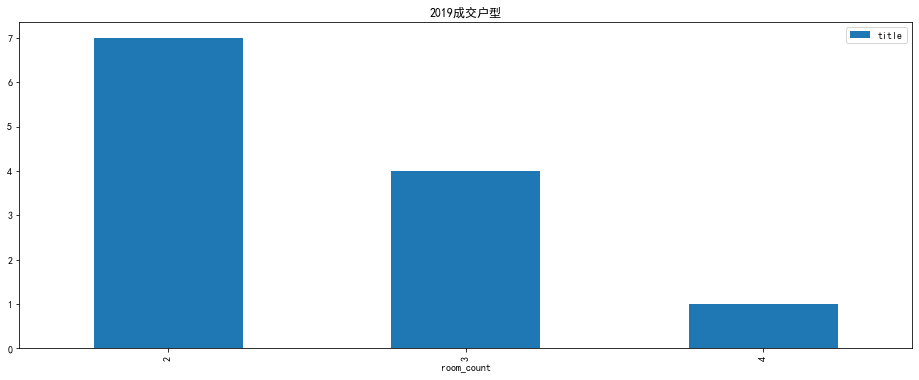

In [19]:
data[data['deal_date']>='2019'].groupby(['room_count']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019成交户型')

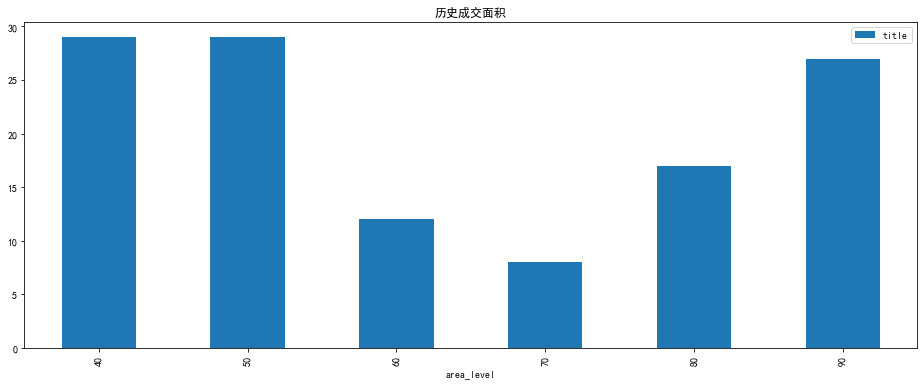

In [20]:
data.groupby(['area_level']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交面积')

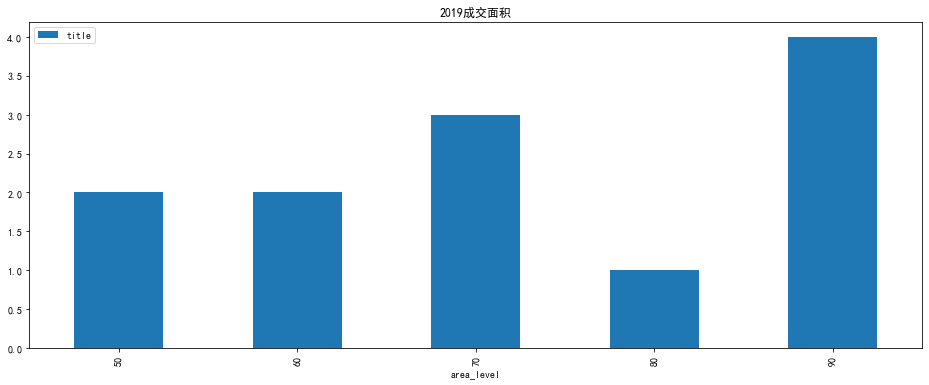

In [21]:
data[data['deal_date']>='2019'].groupby(['area_level']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019成交面积')

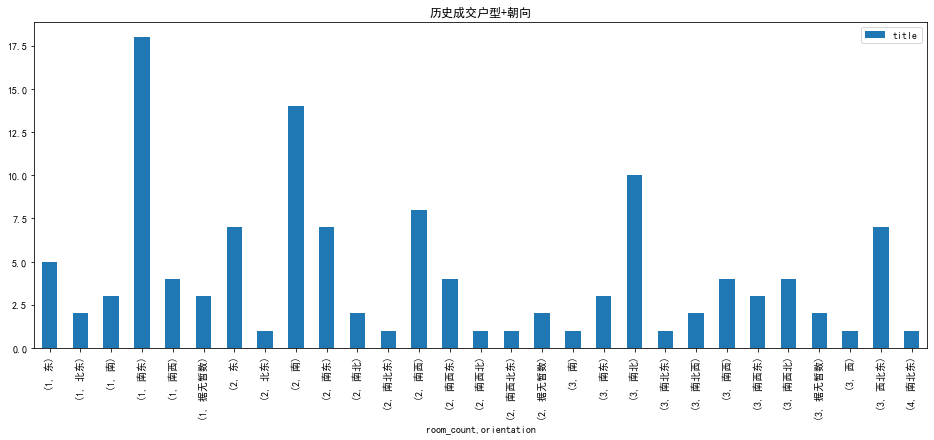

In [22]:
data.groupby(['room_count','orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交户型+朝向')

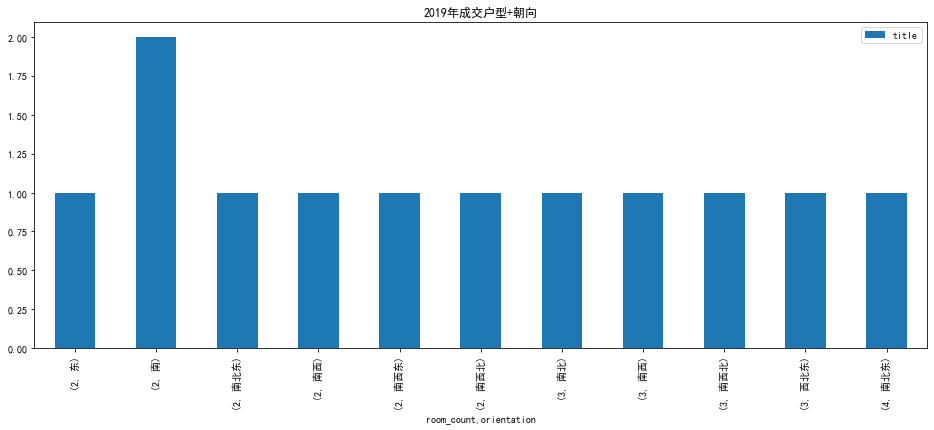

In [23]:
data[data['deal_date']>='2019'].groupby(['room_count','orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019年成交户型+朝向')

分户型朝向和楼层的成交分布

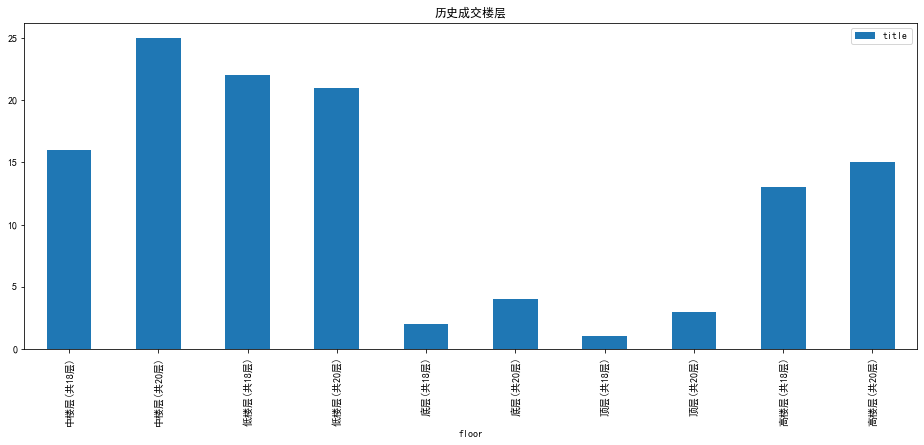

In [24]:
data.groupby(['floor']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交楼层')

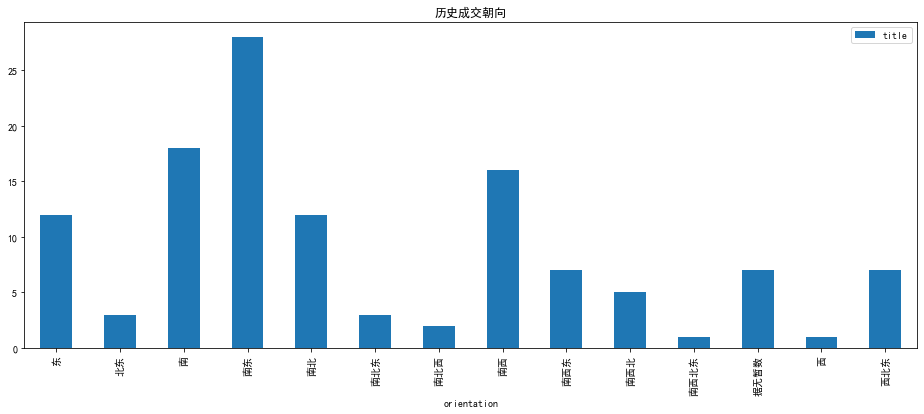

In [25]:
data.groupby(['orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交朝向')

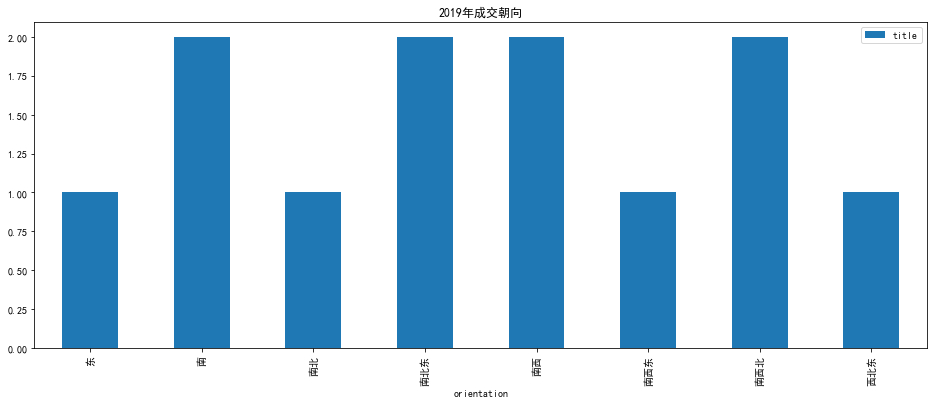

In [26]:
data[data['deal_date']>='2019'].groupby(['orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019年成交朝向')

In [27]:
data.groupby(['house_type','orientation','floor']).count()[['title']]

title
house_type orientation floor           
1室1厅       据无暂数        中楼层(共20层)      1
                       低楼层(共20层)      1
                       高楼层(共18层)      1
1室1厅1厨1卫   东           中楼层(共20层)      3
                       低楼层(共20层)      1
                       高楼层(共20层)      1
           北东          中楼层(共18层)      1
                       高楼层(共20层)      1
           南           低楼层(共18层)      1
                       高楼层(共18层)      1
                       高楼层(共20层)      1
           南东          中楼层(共18层)      4
                       中楼层(共20层)      1
                       低楼层(共18层)      8
                       低楼层(共20层)      2
                       底层(共20层)       1
                       顶层(共20层)       1
                       高楼层(共18层)      1
           南西          中楼层(共18层)      1
                       顶层(共18层)       1
                       高楼层(共18层)      2
2室1厅       据无暂数        中楼层(共18层)      1
                       低楼层(共20层)      1
2室1厅1厨1卫   东           中楼层(共20层)      3
                       底层(共20层)       1
                       高楼层(共20层)      3
           北东          低楼层(共18层)      1
           南           中楼层(共20层)      5
                       低楼层(共18层)      1
                       低楼层(共20层)      4
                       底层(共20层)       1
                       顶层(共20层)       1
                       高楼层(共18层)      1
           南东          中楼层(共18层)      1
                       低楼层(共18层)      2
                       底层(共18层)       1
                       高楼层(共18层)      3
           南北          中楼层(共20层)      1
                       底层(共20层)       1
           南北东         低楼层(共18层)      1
           南西          中楼层(共18层)      1
                       中楼层(共20层)      1
                       高楼层(共18层)      2
                       高楼层(共20层)      2
           南西东         中楼层(共20层)      1
                       低楼层(共18层)      3
2室2厅1厨1卫   南           高楼层(共18层)      1
           南西          中楼层(共18层)      2
           南西北         高楼层(共18层)      1
           南西北东        中楼层(共18层)      1
3室1厅       据无暂数        中楼层(共18层)      1
                       中楼层(共20层)      1
3室1厅1厨1卫   南           底层(共18层)       1
           南东          中楼层(共18层)      1
                       低楼层(共20层)      1
           南北          中楼层(共20层)      5
                       低楼层(共20层)      3
           南北东         低楼层(共20层)      1
           南北西         低楼层(共20层)      1
           南西          中楼层(共18层)      2
           南西东         低楼层(共18层)      1
                       高楼层(共20层)      2
           南西北         中楼层(共20层)      2
                       低楼层(共20层)      1
                       高楼层(共20层)      1
           西           低楼层(共20层)      1
           西北东         中楼层(共20层)      1
                       低楼层(共20层)      2
                       高楼层(共20层)      4
3室2厅1厨1卫   南东          低楼层(共18层)      1
           南北          低楼层(共20层)      1
           南北西         低楼层(共18层)      1
           南西          低楼层(共18层)      2
3室2厅1厨2卫   南北          低楼层(共20层)      1
4室1厅1厨1卫   南北东         顶层(共20层)       1

In [28]:
data.groupby(['area','orientation','floor']).count()[['title']]

title
area  orientation floor           
37.75 南东          底层(共20层)       1
40.20 南东          中楼层(共18层)      2
                  低楼层(共18层)      5
      据无暂数        高楼层(共18层)      1
40.75 北东          中楼层(共18层)      1
      南东          中楼层(共18层)      2
                  低楼层(共18层)      2
41.00 南           高楼层(共18层)      1
41.67 东           中楼层(共20层)      1
      北东          高楼层(共20层)      1
      南           高楼层(共20层)      1
      南东          低楼层(共20层)      1
      据无暂数        低楼层(共20层)      1
43.00 南东          中楼层(共20层)      1
43.39 东           中楼层(共20层)      2
                  低楼层(共20层)      1
                  高楼层(共20层)      1
      南东          低楼层(共20层)      1
                  顶层(共20层)       1
                  高楼层(共18层)      1
44.20 南           底层(共20层)       1
47.82 南           低楼层(共20层)      1
      南西          中楼层(共20层)      1
                  高楼层(共20层)      1
      南西东         中楼层(共20层)      1
48.24 南           中楼层(共20层)      1
                  低楼层(共20层)      1
      南西          高楼层(共20层)      1
49.46 南           低楼层(共18层)      1
      南西          中楼层(共18层)      1
49.74 南东          低楼层(共18层)      1
      南西          顶层(共18层)       1
                  高楼层(共18层)      1
49.95 东           高楼层(共20层)      2
      据无暂数        中楼层(共20层)      1
50.00 东           中楼层(共20层)      3
      南西          高楼层(共18层)      1
50.07 东           底层(共20层)       1
                  高楼层(共20层)      1
52.00 南           顶层(共20层)       1
52.20 南           中楼层(共20层)      3
                  低楼层(共20层)      1
52.44 南           中楼层(共20层)      1
                  低楼层(共20层)      1
      南北          中楼层(共20层)      1
59.18 南           低楼层(共18层)      1
59.34 南东          低楼层(共18层)      1
      南北东         低楼层(共18层)      1
59.44 南           高楼层(共18层)      1
      南东          高楼层(共18层)      1
59.53 据无暂数        中楼层(共18层)      1
59.58 北东          低楼层(共18层)      1
59.79 南东          高楼层(共18层)      2
60.00 南东          低楼层(共18层)      1
61.72 南北          底层(共20层)       1
65.00 南西          中楼层(共18层)      1
65.59 南东          底层(共18层)       1
      南西东         低楼层(共18层)      1
67.80 南西          中楼层(共18层)      1
72.64 南西          高楼层(共18层)      1
      南西东         低楼层(共18层)      1
73.09 南西          高楼层(共18层)      1
      南西东         低楼层(共18层)      1
      南西北         高楼层(共18层)      1
78.74 南东          中楼层(共18层)      1
      南西          中楼层(共18层)      1
      南西北东        中楼层(共18层)      1
79.00 南           高楼层(共18层)      1
80.25 西           低楼层(共20层)      1
      西北东         中楼层(共20层)      1
                  高楼层(共20层)      2
80.54 西北东         低楼层(共20层)      1
                  高楼层(共20层)      2
81.00 西北东         低楼层(共20层)      1
81.77 南           底层(共18层)       1
      南东          低楼层(共18层)      1
      南西东         低楼层(共18层)      1
      据无暂数        中楼层(共18层)      1
82.12 南东          中楼层(共18层)      1
85.44 南北          中楼层(共20层)      2
                  低楼层(共20层)      2
85.66 南北          低楼层(共20层)      1
      南北东         顶层(共20层)       1
86.00 南北          低楼层(共20层)      1
86.55 南北          中楼层(共20层)      1
88.09 南北          低楼层(共20层)      1
      南西北         中楼层(共20层)      1
                  高楼层(共20层)      1
88.24 南北          中楼层(共20层)      2
      南北西         低楼层(共20层)      1
      南西北         中楼层(共20层)      1
                  低楼层(共20层)      1
      据无暂数        低楼层(共20层)      1
89.70 南北东         低楼层(共20层)      1
90.69 南西东         高楼层(共20层)      2
91.25 南东          低楼层(共20层)      1
      据无暂数        中楼层(共20层)      1
93.82 南西          低楼层(共18层)      1
93.99 南北西         低楼层(共18层)      1
      南西          中楼层(共18层)      1
94.00 南西          中楼层(共18层)      1
                  低楼层(共18层)      1

In [29]:
data.groupby(['area']).count()[['title']]

,title
area,
37.75,1
40.20,8
40.75,5
41.00,1
41.67,5
43.00,1
43.39,7
44.20,1
47.82,4


### 2）换手率

分户型分析换手情况

成交超过1次，分户型交易占比

In [30]:
data.groupby(['room_count', 'history_trade_count']).count()[['title']]

title
room_count history_trade_count       
1          1                       27
           2                        8
2          1                       44
           2                        4
3          1                       32
           2                        6
4          1                        1

In [31]:
(data[data['history_trade_count']>1].groupby('room_count').count()/2/data.groupby('room_count').count())[['title']]

,title
room_count,
1,0.114286
2,0.041667
3,0.078947
4,NaN


### 3）带看与成交周期

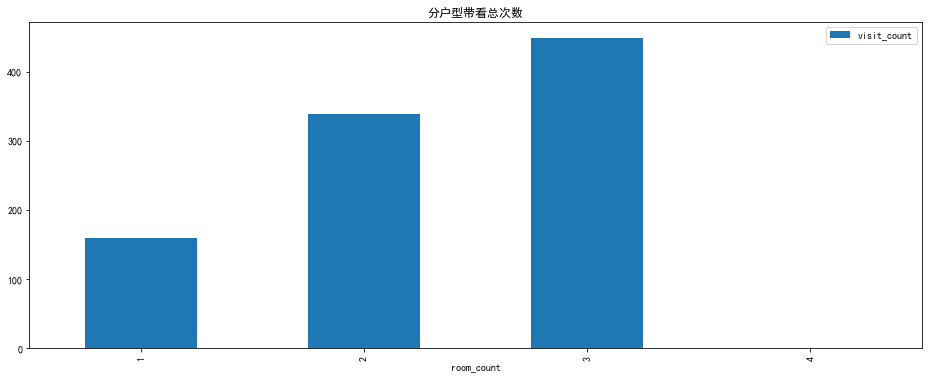

In [32]:
data.groupby(['room_count']).sum()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型带看总次数')

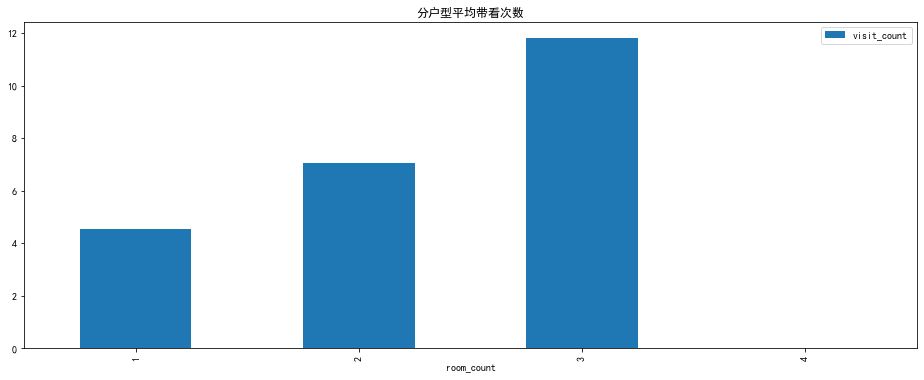

In [33]:
data.groupby(['room_count']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型平均带看次数')

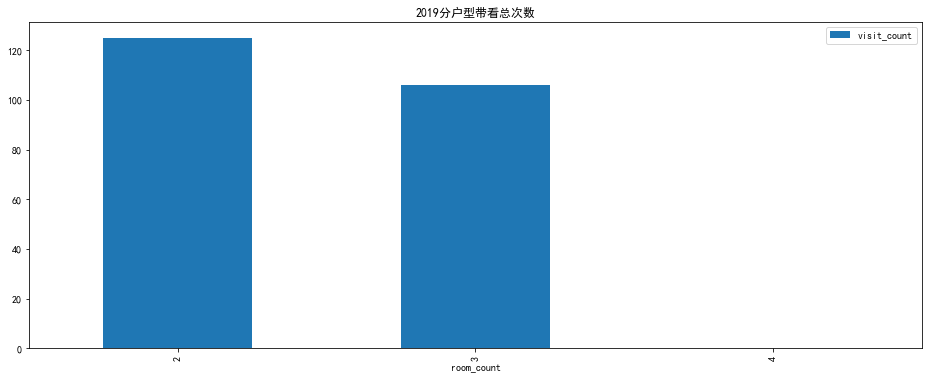

In [34]:
data[data['deal_date']>='2019'].groupby(['room_count']).sum()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019分户型带看总次数')

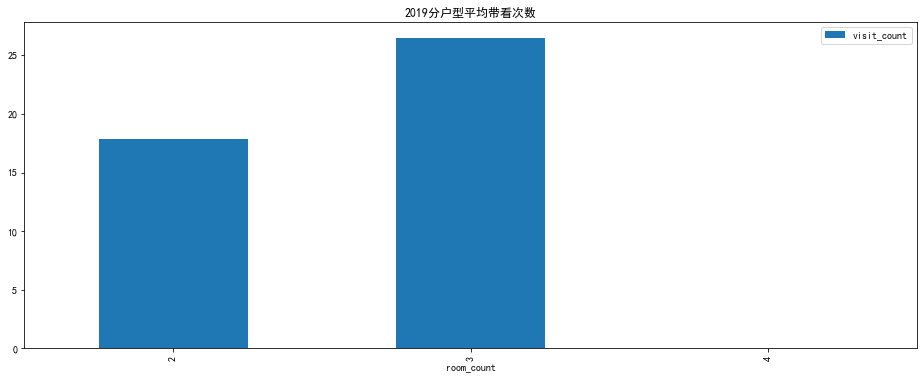

In [35]:
data[data['deal_date']>='2019'].groupby(['room_count']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019分户型平均带看次数')

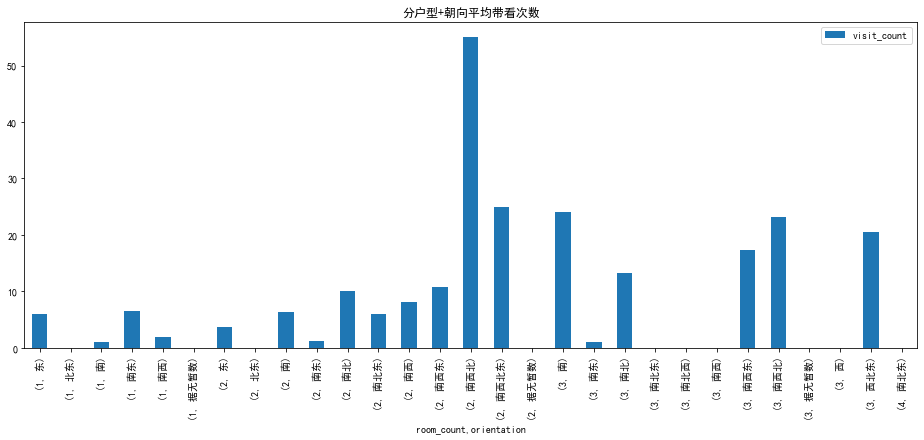

In [36]:
data.groupby(['room_count','orientation']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型+朝向平均带看次数')

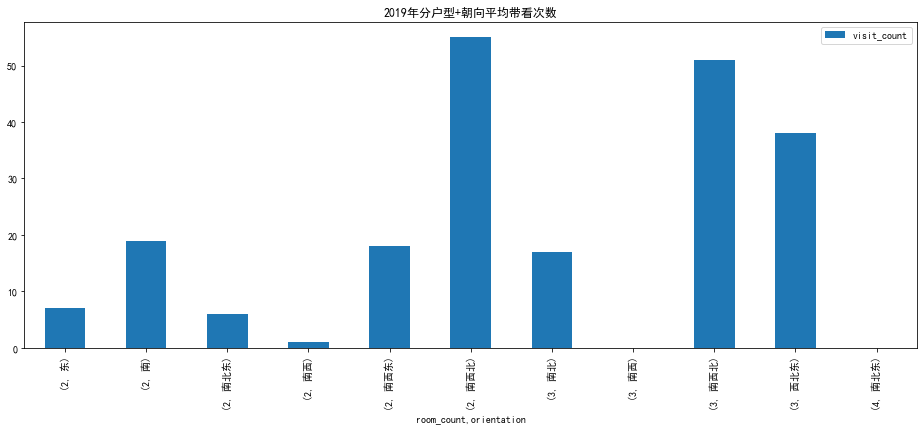

In [37]:
data[data['deal_date']>='2019'].groupby(['room_count','orientation']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019年分户型+朝向平均带看次数')

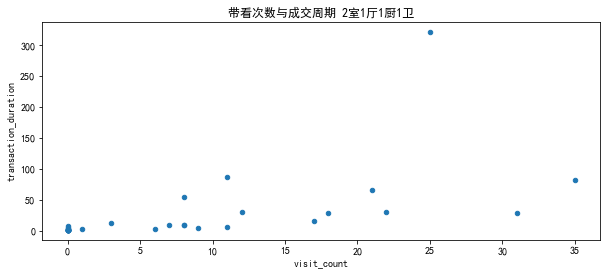

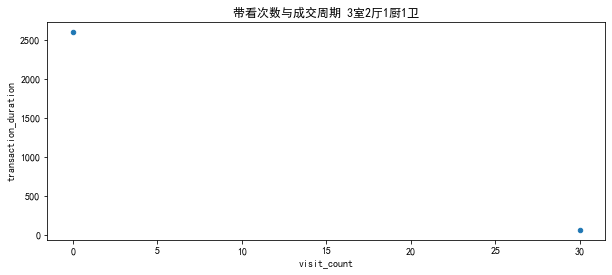

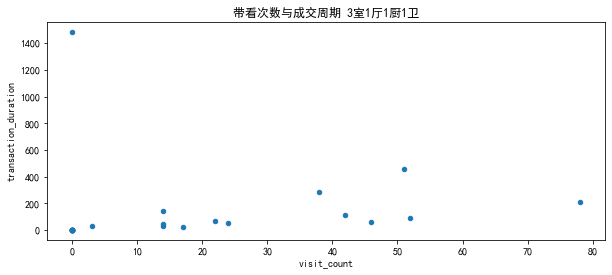

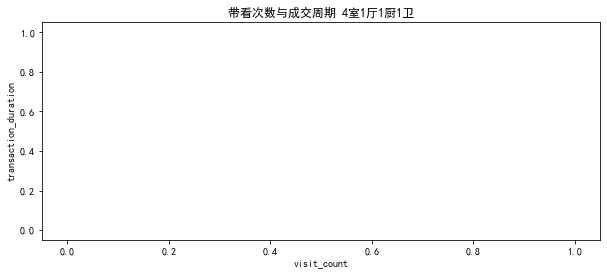

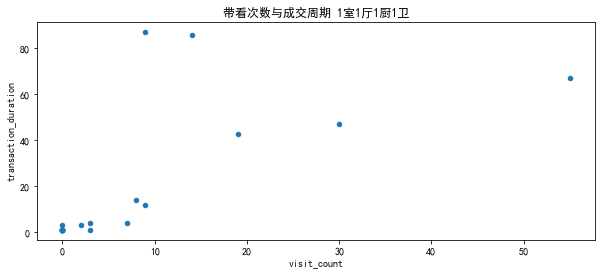

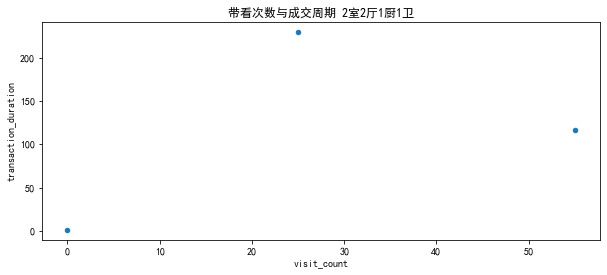

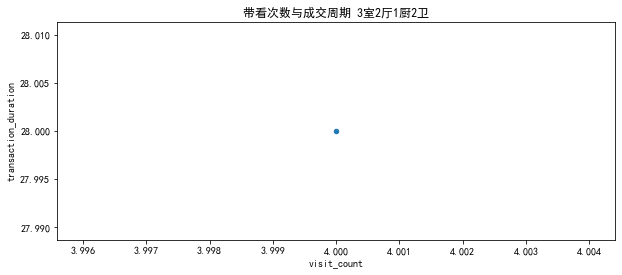

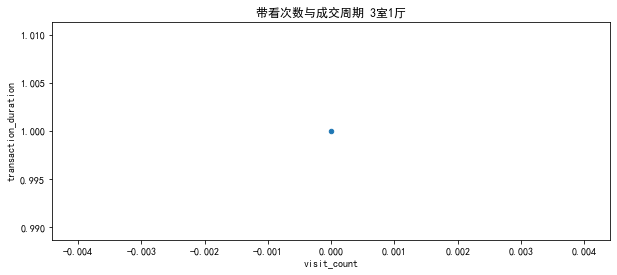

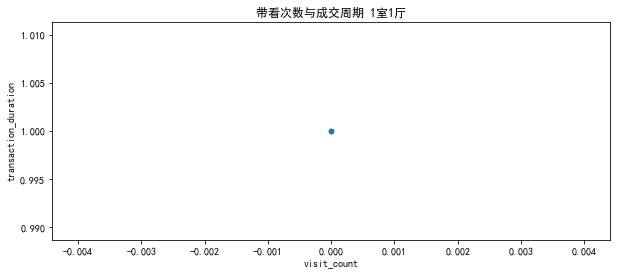

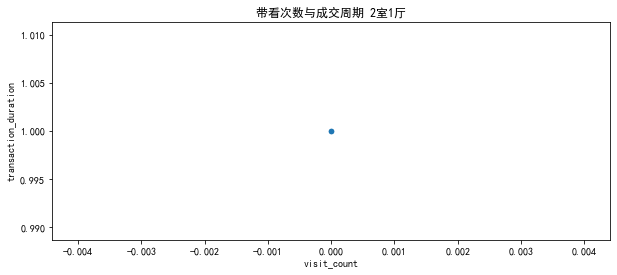

In [38]:
for t in data['house_type'].unique():
    data[data['house_type']==t][['transaction_duration','visit_count']].plot(kind='scatter',x='visit_count', y='transaction_duration',figsize=(10,4),title='带看次数与成交周期 '+t)

分户型成交周期分布

In [39]:
data.groupby(['room_count','orientation','floor']).describe()[['transaction_duration']]

transaction_duration               \
                                                count         mean   
room_count orientation floor                                         
1          东           中楼层(共20层)                  1.0    47.000000   
                       低楼层(共20层)                  0.0          NaN   
                       高楼层(共20层)                  0.0          NaN   
           北东          中楼层(共18层)                  1.0     1.000000   
                       高楼层(共20层)                  1.0     1.000000   
           南           低楼层(共18层)                  1.0     1.000000   
                       高楼层(共18层)                  1.0     1.000000   
                       高楼层(共20层)                  0.0          NaN   
           南东          中楼层(共18层)                  3.0     2.666667   
                       中楼层(共20层)                  1.0     1.000000   
                       低楼层(共18层)                  6.0    41.333333   
                       低楼层(共20层)                  1.0    12.000000   
                       底层(共20层)                   1.0    43.000000   
                       顶层(共20层)                   0.0          NaN   
                       高楼层(共18层)                  1.0     1.000000   
           南西          中楼层(共18层)                  1.0    14.000000   
                       顶层(共18层)                   1.0     1.000000   
                       高楼层(共18层)                  1.0     1.000000   
           据无暂数        中楼层(共20层)                  1.0     1.000000   
                       低楼层(共20层)                  1.0     1.000000   
                       高楼层(共18层)                  1.0     1.000000   
2          东           中楼层(共20层)                  3.0     3.666667   
                       底层(共20层)                   1.0     1.000000   
                       高楼层(共20层)                  3.0     5.333333   
           北东          低楼层(共18层)                  0.0          NaN   
           南           中楼层(共20层)                  4.0     6.750000   
                       低楼层(共18层)                  1.0     8.000000   
                       低楼层(共20层)                  4.0     2.750000   
                       底层(共20层)                   1.0    82.000000   
                       顶层(共20层)                   1.0     1.000000   
                       高楼层(共18层)                  2.0    33.500000   
           南东          中楼层(共18层)                  0.0          NaN   
                       低楼层(共18层)                  1.0     1.000000   
                       底层(共18层)                   0.0          NaN   
                       高楼层(共18层)                  2.0     6.500000   
           南北          中楼层(共20层)                  1.0    55.000000   
                       底层(共20层)                   1.0    30.000000   
           南北东         低楼层(共18层)                  1.0     2.000000   
           南西          中楼层(共18层)                  1.0     1.000000   
                       中楼层(共20层)                  1.0    30.000000   
                       高楼层(共18层)                  2.0    45.000000   
                       高楼层(共20层)                  2.0    15.000000   
           南西东         中楼层(共20层)                  1.0   321.000000   
                       低楼层(共18层)                  3.0    11.333333   
           南西北         高楼层(共18层)                  1.0   116.000000   
           南西北东        中楼层(共18层)                  1.0   229.000000   
           据无暂数        中楼层(共18层)                  1.0     1.000000   
                       低楼层(共20层)                  1.0     1.000000   
3          南           底层(共18层)                   1.0    50.000000   
           南东          中楼层(共18层)                  0.0          NaN   
                       低楼层(共18层)                  0.0          NaN   
                       低楼层(共20层)                  1.0    29.000000   
           南北          中楼层(共20层)                  4.0    29.750000   
                       低楼层(共20层)                  5.0    35.400000   
           南北东         低楼层(共20层)           

tuple index out of range 3室2厅1厨1卫
tuple index out of range 4室1厅1厨1卫
tuple index out of range 2室2厅1厨1卫
tuple index out of range 3室2厅1厨2卫
tuple index out of range 3室1厅
tuple index out of range 1室1厅
tuple index out of range 2室1厅


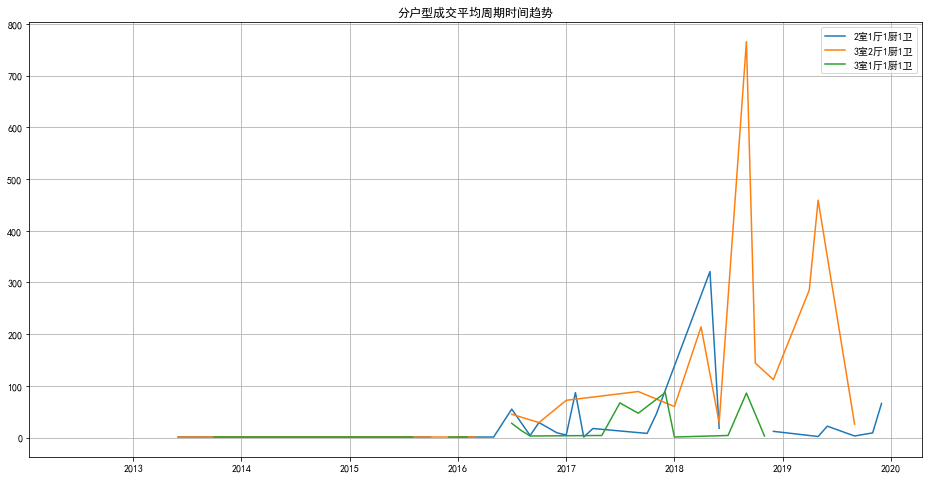

In [40]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    try:
        plt.plot(data[data['house_type']==t].groupby(['deal_month']).mean()['transaction_duration'])
    except Exception as e:
        print(e,t)
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.title('分户型成交平均周期时间趋势')
plt.show()

### 4) 成交量时间趋势

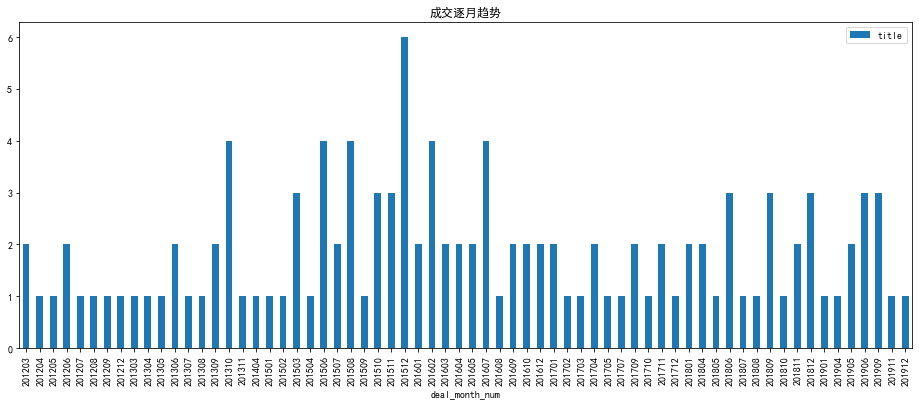

In [41]:
data.groupby('deal_month_num').count()[['title']].plot(kind='bar', figsize=(16,6), title='成交逐月趋势')
#ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))

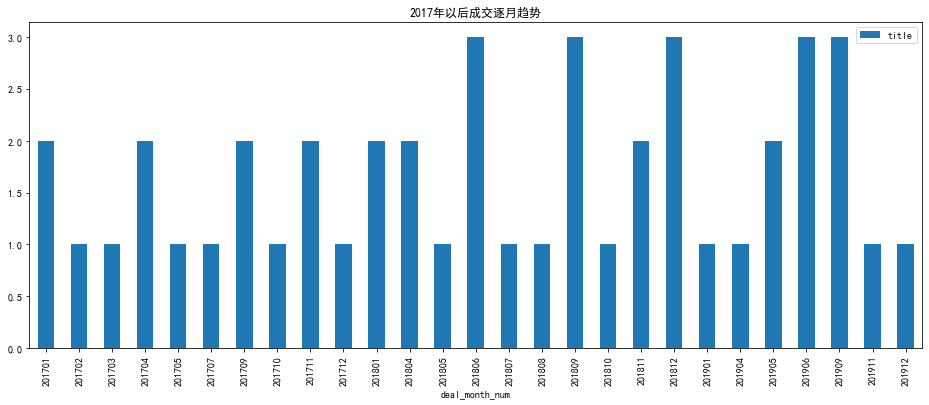

In [43]:
data[data['deal_date']>='2017'].groupby('deal_month_num').count()[['title']].plot(kind='bar', figsize=(16,6), title='2017年以后成交逐月趋势')

## 2.2 价格机制

相同面积，房间数下，影响价格的因素主要是朝向和楼层

### 1）分户型平均成交价格走势（去除非链家成交）

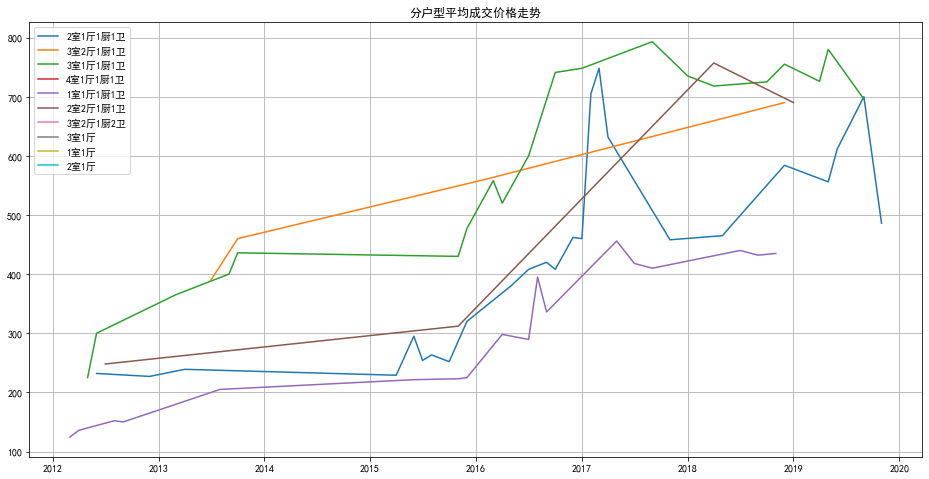

In [44]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    plt.plot(data[(data['house_type']==t) & (data['is_lianjia_deal']==True)].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.title('分户型平均成交价格走势')
plt.show()

### 2）2019年分户型不同楼层成交均价

In [45]:
data[(data['deal_date']>'2019') & (data['is_lianjia_deal']==True) ].groupby(['house_type','area','floor', 'build_year'])[['transaction_price','per_area_price']].mean()

transaction_price  per_area_price
house_type area  floor     build_year                                   
2室1厅1厨1卫   50.07 高楼层(共20层) 1993                      486        9.706411
           52.20 中楼层(共20层) 1993                      513        9.827586
           59.34 低楼层(共18层) 1996                      556        9.369734
           73.09 低楼层(共18层) 1996                      710        9.714051
                 高楼层(共18层) 1996                      700        9.577234
2室2厅1厨1卫   73.09 高楼层(共18层) 1996                      690        9.440416
3室1厅1厨1卫   80.54 高楼层(共20层) 1993                      726        9.014154
           88.09 中楼层(共20层) 1995                      780        8.854581
                 低楼层(共20层) 1995                      696        7.901010

### 3）各个户型最后成交价格

户型锚定价格

In [47]:
data.sort_values('deal_date').groupby(['house_type','area','floor'])[['transaction_price','deal_date','is_lianjia_deal','lianjia_id']].last()

transaction_price  deal_date  is_lianjia_deal  \
house_type area  floor                                                      
1室1厅       40.20 高楼层(共18层)                205 2015-03-01            False   
           41.67 低楼层(共20层)                220 2015-07-01            False   
           49.95 中楼层(共20层)                230 2015-02-01            False   
1室1厅1厨1卫   37.75 底层(共20层)                 263 2016-07-30             True   
           40.20 中楼层(共18层)                456 2017-05-22             True   
                 低楼层(共18层)                432 2018-09-19             True   
           40.75 中楼层(共18层)                435 2018-11-17             True   
                 低楼层(共18层)                440 2018-07-12             True   
           41.00 高楼层(共18层)                215 2013-10-01            False   
           41.67 中楼层(共20层)                200 2015-12-13             True   
                 低楼层(共20层)                316 2016-07-27             True   
                 高楼层(共20层)                205 2015-08-01            False   
           43.00 中楼层(共20层)                195 2013-05-01            False   
           43.39 中楼层(共20层)                410 2017-09-13             True   
                 低楼层(共20层)                445 2018-11-01            False   
                 顶层(共20层)                 136 2012-04-17             True   
                 高楼层(共18层)                218 2013-11-01            False   
                 高楼层(共20层)                119 2012-03-19             True   
           49.46 中楼层(共18层)                395 2016-08-21             True   
                 低楼层(共18层)                450 2018-01-01            False   
           49.74 低楼层(共18层)                250 2015-12-12             True   
                 顶层(共18层)                 250 2015-12-01            False   
                 高楼层(共18层)                235 2015-06-02             True   
           50.00 高楼层(共18层)                271 2016-02-01            False   
2室1厅       59.53 中楼层(共18层)                150 2015-06-01            False   
           88.24 低楼层(共20层)                430 2014-04-01            False   
2室1厅1厨1卫   44.20 底层(共20层)                 375 2017-11-01            False   
           47.82 中楼层(共20层)                465 2018-05-13             True   
                 低楼层(共20层)                460 2017-01-17             True   
                 高楼层(共20层)                235 2015-08-24             True   
           48.24 中楼层(共20层)                458 2017-11-19             True   
                 低楼层(共20层)                235 2015-08-23             True   
                 高楼层(共20层)                408 2016-10-21             True   
           49.95 高楼层(共20层)                483 2018-06-20             True   
           50.00 中楼层(共20层)                462 2016-12-25             True   
           50.07 底层(共20层)                 229 2015-04-15             True   
                 高楼层(共20层)                486 2019-11-13             True   
           52.00 顶层(共20层)                 246 2013-06-01            False   
           52.20 中楼层(共20层)                513 2019-06-21             True   
                 低楼层(共20层)                254 2015-07-04             True   
           52.44 中楼层(共20层)                408 2016-07-31             True   
                 低楼层(共20层)                420 2016-09-11             True   
           59.18 低楼层(共18层)                556 2017-10-01            False   
           59.34 低楼层(共18层)                556 2019-05-01             True   
           59.44 高楼层(共18层)                605 2019-12-01            False   
           59.58 低楼层(共18层)                227 2012-12-24             True   
           59.79 高楼层(共18层)                584 2018-12-21             True   
           60.00 低楼层(共18层)                286 2015-03-01            False   
           61.72 底层(共20层)                 482 2018-06-21             True   
           65.00 中楼层(共18层)                340 2015-10-01            False   
           65.59 低楼层(共18

### 4）分户型楼层以及时间，挂牌价与成交价gap分布

In [48]:
#data.groupby(['house_type','area','floor','deal_year'])[['transaction_listed_price_gap']].describe()
data[data['is_lianjia_deal']==True].groupby(['house_type','deal_year'])[['transaction_listed_price_gap']].describe()

transaction_listed_price_gap                        \
                                             count       mean        std   
house_type deal_year                                                       
1室1厅1厨1卫   2012-01-01                          5.0  -3.200000   3.633180   
           2013-01-01                          1.0  -5.000000        NaN   
           2015-01-01                          5.0  -4.800000   4.816638   
           2016-01-01                          5.0  -6.400000   7.092249   
           2017-01-01                          3.0 -14.666667   7.023769   
           2018-01-01                          3.0 -11.000000   6.557439   
2室1厅1厨1卫   2012-01-01                          2.0  -3.000000   0.000000   
           2013-01-01                          1.0  -1.000000        NaN   
           2015-01-01                          8.0  -5.375000   3.662064   
           2016-01-01                          5.0  -6.200000   4.919350   
           2017-01-01                          6.0  -5.666667  11.535453   
           2018-01-01                          4.0 -23.750000  18.136060   
           2019-01-01                          5.0 -22.200000   8.955445   
2室2厅1厨1卫   2012-01-01                          1.0   0.000000        NaN   
           2015-01-01                          1.0 -18.000000        NaN   
           2018-01-01                          1.0 -30.000000        NaN   
           2019-01-01                          1.0  -8.000000        NaN   
3室1厅1厨1卫   2012-01-01                          2.0  -7.500000   3.535534   
           2013-01-01                          3.0  -1.333333   2.309401   
           2015-01-01                          2.0 -10.500000  10.606602   
           2016-01-01                          4.0 -15.250000   9.912114   
           2017-01-01                          2.0 -19.500000  24.748737   
           2018-01-01                          4.0 -22.500000  16.583124   
           2019-01-01                          3.0 -37.666667  23.671361   
3室2厅1厨1卫   2013-01-01                          2.0  -4.500000   6.363961   
           2016-01-01                          1.0 -20.000000        NaN   
           2018-01-01                          1.0 -38.000000        NaN   
3室2厅1厨2卫   2016-01-01                          1.0  -5.000000        NaN   

                                                       
                        min    25%   50%    75%   max  
house_type deal_year                                   
1室1厅1厨1卫   2012-01-01  -8.0  -6.00  -2.0   0.00   0.0  
           2013-01-01  -5.0  -5.00  -5.0  -5.00  -5.0  
           2015-01-01 -10.0 -10.00  -2.0  -2.00   0.0  
           2016-01-01 -19.0  -4.00  -4.0  -3.00  -2.0  
           2017-01-01 -22.0 -18.00 -14.0 -11.00  -8.0  
           2018-01-01 -18.0 -14.00 -10.0  -7.50  -5.0  
2室1厅1厨1卫   2012-01-01  -3.0  -3.00  -3.0  -3.00  -3.0  
           2013-01-01  -1.0  -1.00  -1.0  -1.00  -1.0  
           2015-01-01 -10.0  -8.00  -6.0  -3.75   0.0  
           2016-01-01 -11.0 -10.00  -8.0  -2.00   0.0  
           2017-01-01 -27.0  -8.00  -1.0   0.00   5.0  
           2018-01-01 -48.0 -30.75 -21.0 -14.00  -5.0  
           2019-01-01 -34.0 -27.00 -20.0 -20.00 -10.0  
2室2厅1厨1卫   2012-01-01   0.0   0.00   0.0   0.00   0.0  
           2015-01-01 -18.0 -18.00 -18.0 -18.00 -18.0  
           2018-01-01 -30.0 -30.00 -30.0 -30.00 -30.0  
           2019-01-01  -8.0  -8.00  -8.0  -8.00  -8.0  
3室1厅1厨1卫   2012-01-01 -10.0  -8.75  -7.5  -6.25  -5.0  
           2013-01-01  -4.0  -2.00   0.0   0.00   0.0  
           2015-01-01 -18.0 -14.25 -10.5  -6.75  -3.0  
           2016-01-01 -30.0 -16.50 -11.0  -9.75  -9.0  
           2017-01-01 -37.0 -28.25 -19.5 -10.75  -2.0  
           2018-01-01 -45.0 -26.25 -20.0 -16.25  -5.0  
           2019-01-01 -65.0 -44.50 -24.0 -24.00 -24.0  
3室2厅1厨1卫   2013-01-01  -9.0  -6.75  -4.5  -2.25   0.0  
           2016-01-01 -20.0 -20.00 -20.0 -20.00 -20.0  
           2018-01-01 -38.0 -38.00 -38.0 

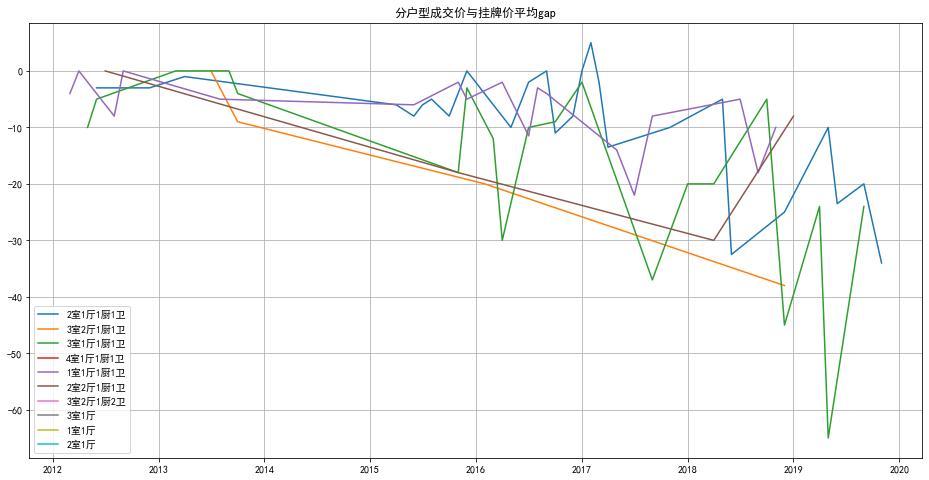

In [49]:
#plt.figure(figsize=(16, 8))
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    plt.plot(data[(data['house_type']==t) & (data['is_lianjia_deal']==True)].groupby(['deal_month']).mean()['transaction_listed_price_gap'].astype(float))
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.title('分户型成交价与挂牌价平均gap')
plt.show()

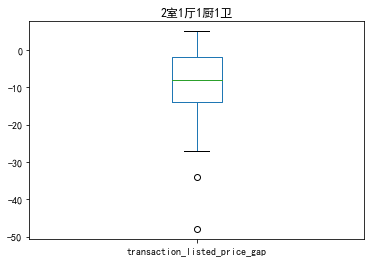

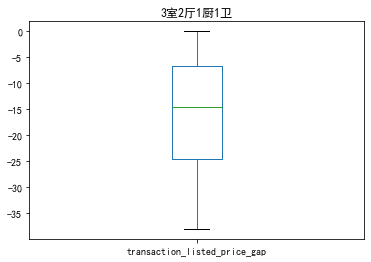

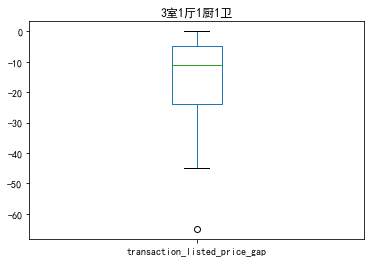

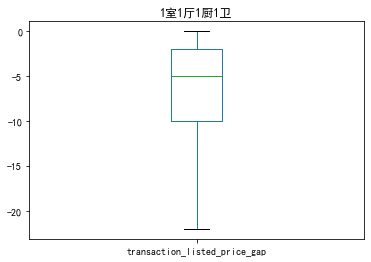

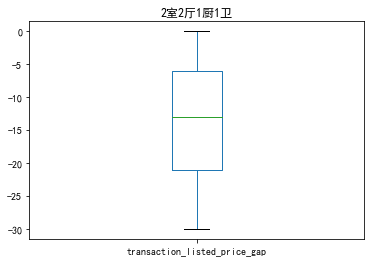

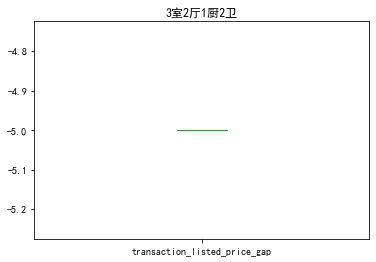

In [50]:

for t in data['house_type'].unique():
    try:
        data[(data['house_type']==t) & (data['is_lianjia_deal'] == True)][['transaction_listed_price_gap']].plot(kind='box', title=t)
    except:
        continue


In [51]:
#pd.plotting.scatter_matrix(data['transaction_duration','visit_count'], alpha = 0.3, figsize = (14,8), diagonal = 'kde');
#import matplotlib.pyplot as plt
#transaction_duration=data['transaction_duration']
#plt.figure(figsize=(20, 5))
#for i, col in enumerate(['visit_count']):
#    plt.subplot(1, 3, i+1)
#    plt.plot(data[col], transaction_duration, 'o')
#    plt.title(col)
#    plt.xlabel(col)
#plt.ylabel('transaction_duration')

### 5) 候选目标户型价格分析

In [52]:
#candidate = data[(abs((data['area']-55))<=1) & (data['deal_year']>='2017')]
#candidate = data[(data['area_level']==50) & (data['deal_year']>='2017')]
candidate = data[(data['room_count']==2) & (data['deal_year']>='2017')]

In [53]:
candidate.groupby('floor').count()[['title']]

,title
floor,
中楼层(共18层),1
中楼层(共20层),4
低楼层(共18层),5
低楼层(共20层),1
底层(共20层),2
高楼层(共18层),6
高楼层(共20层),2


In [54]:
candidate.groupby('last_transaction_duration').count()[['title']]

,title
last_transaction_duration,
暂无数据,6
满五年,15


In [60]:
candidate[['title','deal_month', 'floor', 'orientation', 'transaction_price', 'per_area_price', 'last_transaction_duration','lianjia_id','is_lianjia_deal']].sort_values('deal_month').tail(100)

,title,deal_month,floor,orientation,transaction_price,per_area_price,last_transaction_duration,lianjia_id,is_lianjia_deal
58,安定路 2室1厅 47.82平米,2017-01-01,低楼层(共20层),南,460,9.619406,满五年,101101069747,True
59,安定路 2室1厅 72.64平米,2017-02-01,高楼层(共18层),南西,705,9.705396,暂无数据,101100912064,True
40,安定路 2室1厅 72.64平米,2017-03-01,低楼层(共18层),南西东,748,10.297357,满五年,101101289917,True
41,安定路 2室1厅 65.59平米,2017-04-01,低楼层(共18层),南西东,730,11.129745,满五年,101101448184,True
36,安定路 2室1厅 47.82平米,2017-04-01,中楼层(共20层),南西,533,11.145964,满五年,101101384686,True
32,安定路 2室1厅 59.18平米,2017-10-01,低楼层(共18层),南,556,9.395066,暂无数据,101102116815,False
34,安定路 2室1厅 48.24平米,2017-11-01,中楼层(共20层),南,458,9.494196,暂无数据,101102292730,True
33,安定路 2室1厅 44.2平米,2017-11-01,底层(共20层),南,375,8.484163,满五年,101101934818,False
18,安定路 2室2厅 78.74平米,2018-04-01,中楼层(共18层),南西北东,757,9.613919,满五年,101102026602,True
19,安定路 2室1厅 47.82平米,2018-05-01,中楼层(共20层),南西东,465,9.723965,满五年,101101743084,True


In [56]:
# 目标楼层
candidate[candidate['floor']=='底层(共6层)'][['title','deal_month', 'floor', 'transaction_price', 'last_transaction_duration','lianjia_id','is_lianjia_deal']].sort_values('deal_month').head(100)

,title,deal_month,floor,transaction_price,last_transaction_duration,lianjia_id,is_lianjia_deal


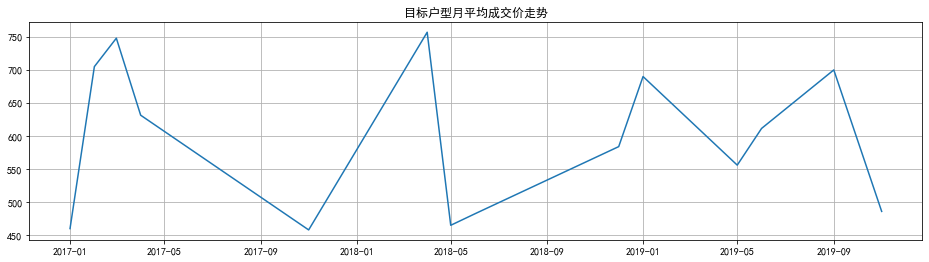

In [57]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
plt.plot(candidate[candidate['is_lianjia_deal']==True].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.title('目标户型月平均成交价走势')
plt.show()

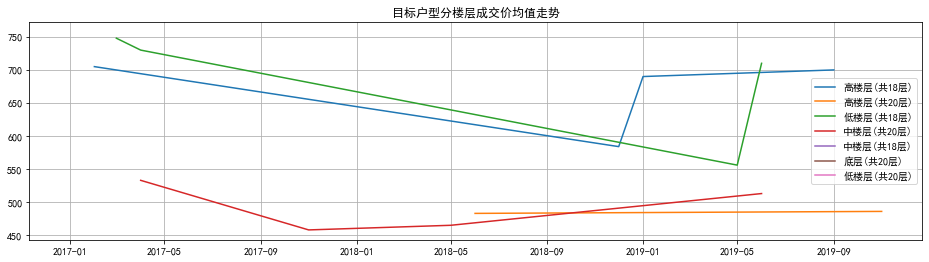

In [61]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in candidate['floor'].unique():
    plt.plot(candidate[(candidate['floor']==t)&(candidate['is_lianjia_deal']==True)].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(candidate['floor'].unique(),loc='best')
plt.title('目标户型分楼层成交价均值走势')
plt.show()

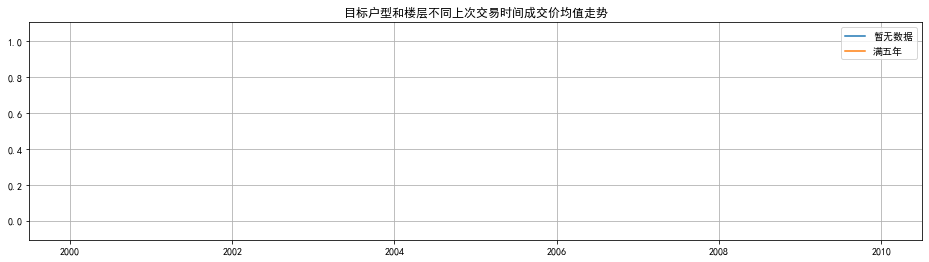

In [62]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in candidate['last_transaction_duration'].unique():
    plt.plot(candidate[(candidate['last_transaction_duration']==t) & (candidate['floor']=='底层(共6层)') ].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(candidate['last_transaction_duration'].unique(),loc='best')
plt.title('目标户型和楼层不同上次交易时间成交价均值走势')
plt.show()

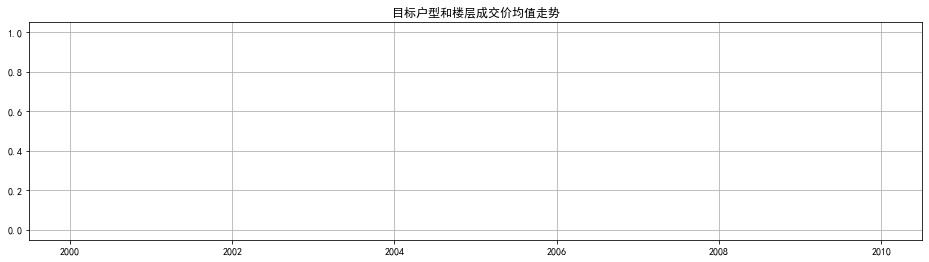

In [63]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
plt.plot(candidate[(candidate['floor']=='底层(共6层)') & (candidate['is_lianjia_deal']==True)].groupby(['deal_month']).mean()['transaction_price'])
#plt.plot(candidate.groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.title('目标户型和楼层成交价均值走势')
plt.show()

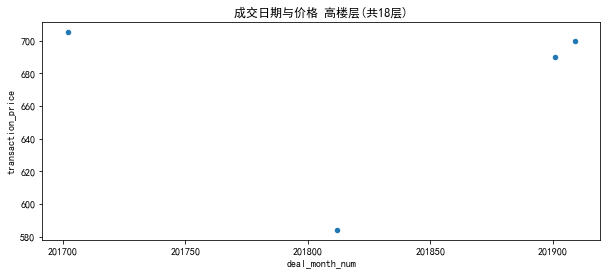

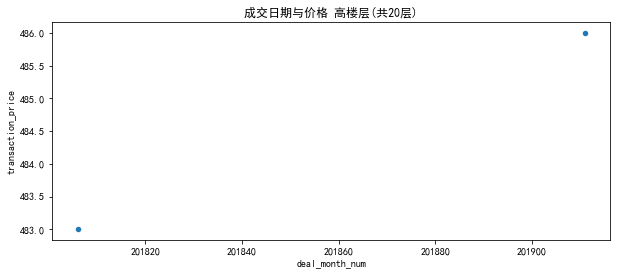

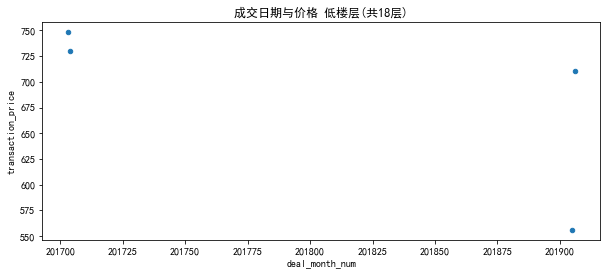

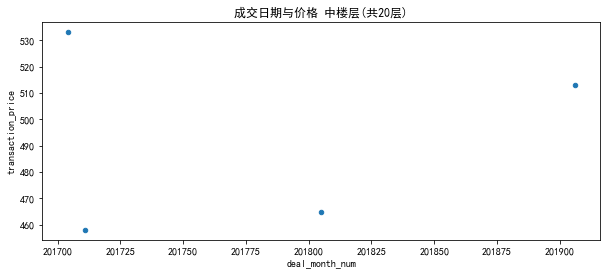

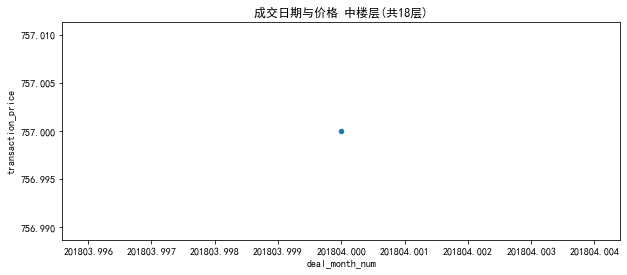

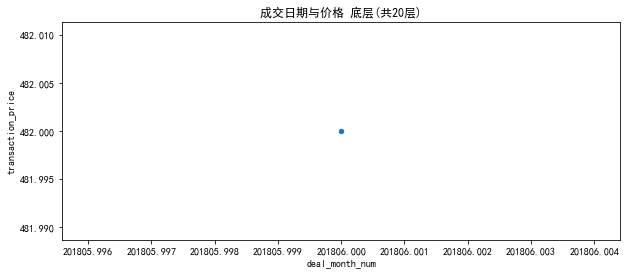

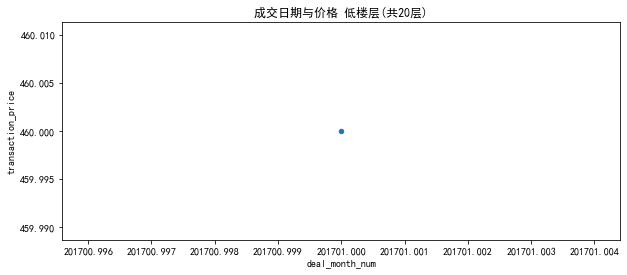

In [64]:
for t in candidate['floor'].unique():
    ax=candidate[(candidate['floor']==t)&(candidate['is_lianjia_deal']==True)][['transaction_price','deal_month_num']].plot(kind='scatter',x='deal_month_num', y='transaction_price',figsize=(10,4),title='成交日期与价格 '+t)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)

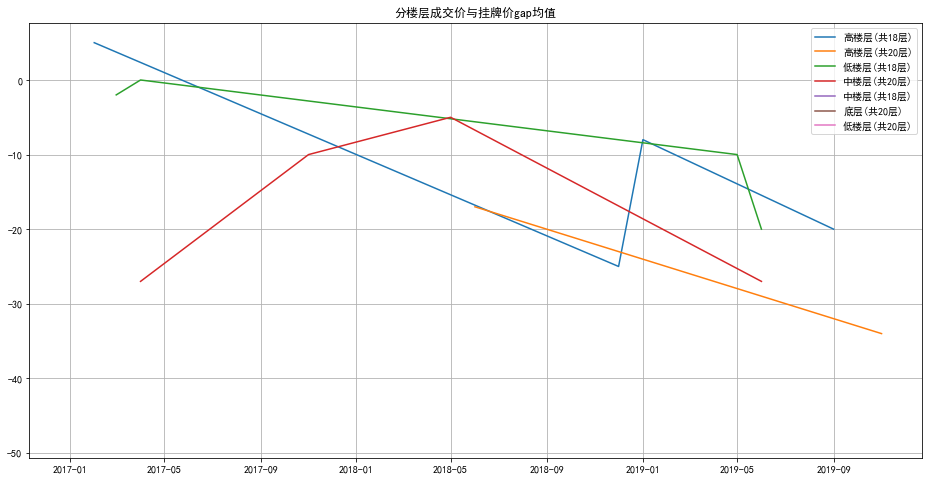

In [65]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in candidate['floor'].unique():
    plt.plot(candidate[(candidate['floor']==t)&(candidate['is_lianjia_deal']==True)].groupby(['deal_month']).mean()['transaction_listed_price_gap'].astype(float))
plt.grid(True)
plt.legend(candidate['floor'].unique(),loc='best')
plt.title('分楼层成交价与挂牌价gap均值')
plt.show()

价格gap线框图分布

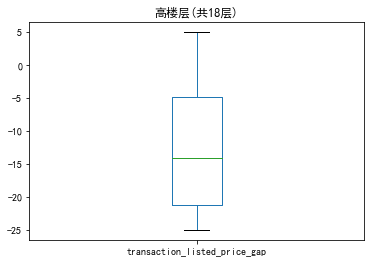

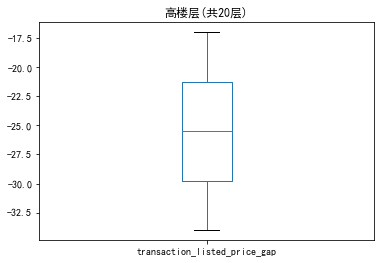

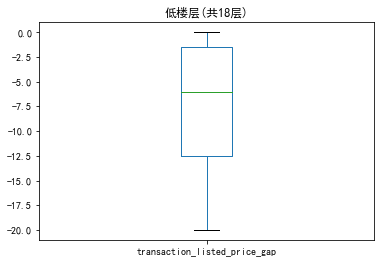

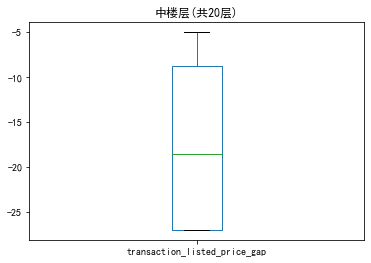

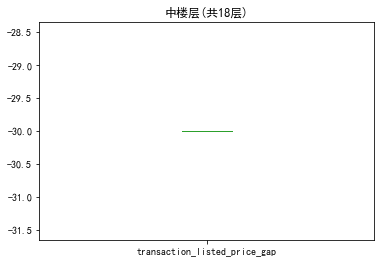

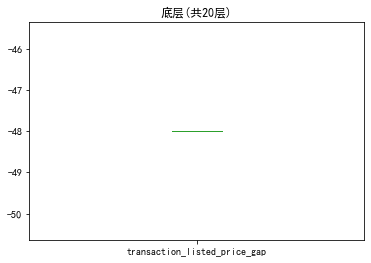

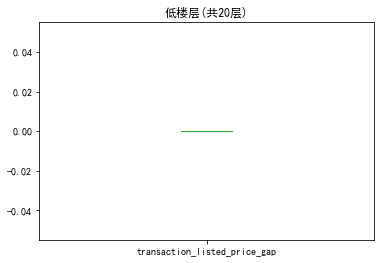

In [66]:
for t in candidate['floor'].unique():
    candidate[(candidate['floor']==t)&(candidate['is_lianjia_deal']==True)][['transaction_listed_price_gap']].plot(kind='box', title=t)


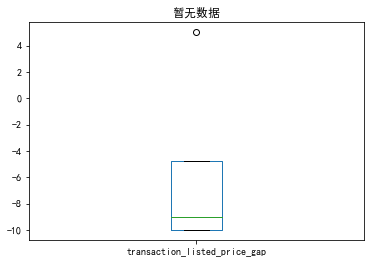

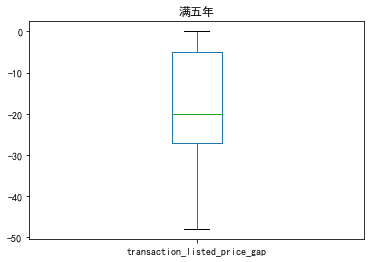

In [67]:
for t in candidate['last_transaction_duration'].unique():
    candidate[(candidate['last_transaction_duration']==t)&(candidate['is_lianjia_deal']==True)][['transaction_listed_price_gap']].plot(kind='box', title=t)